### EDA

In [96]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [97]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using multi-GPU
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [98]:
#reding from here https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

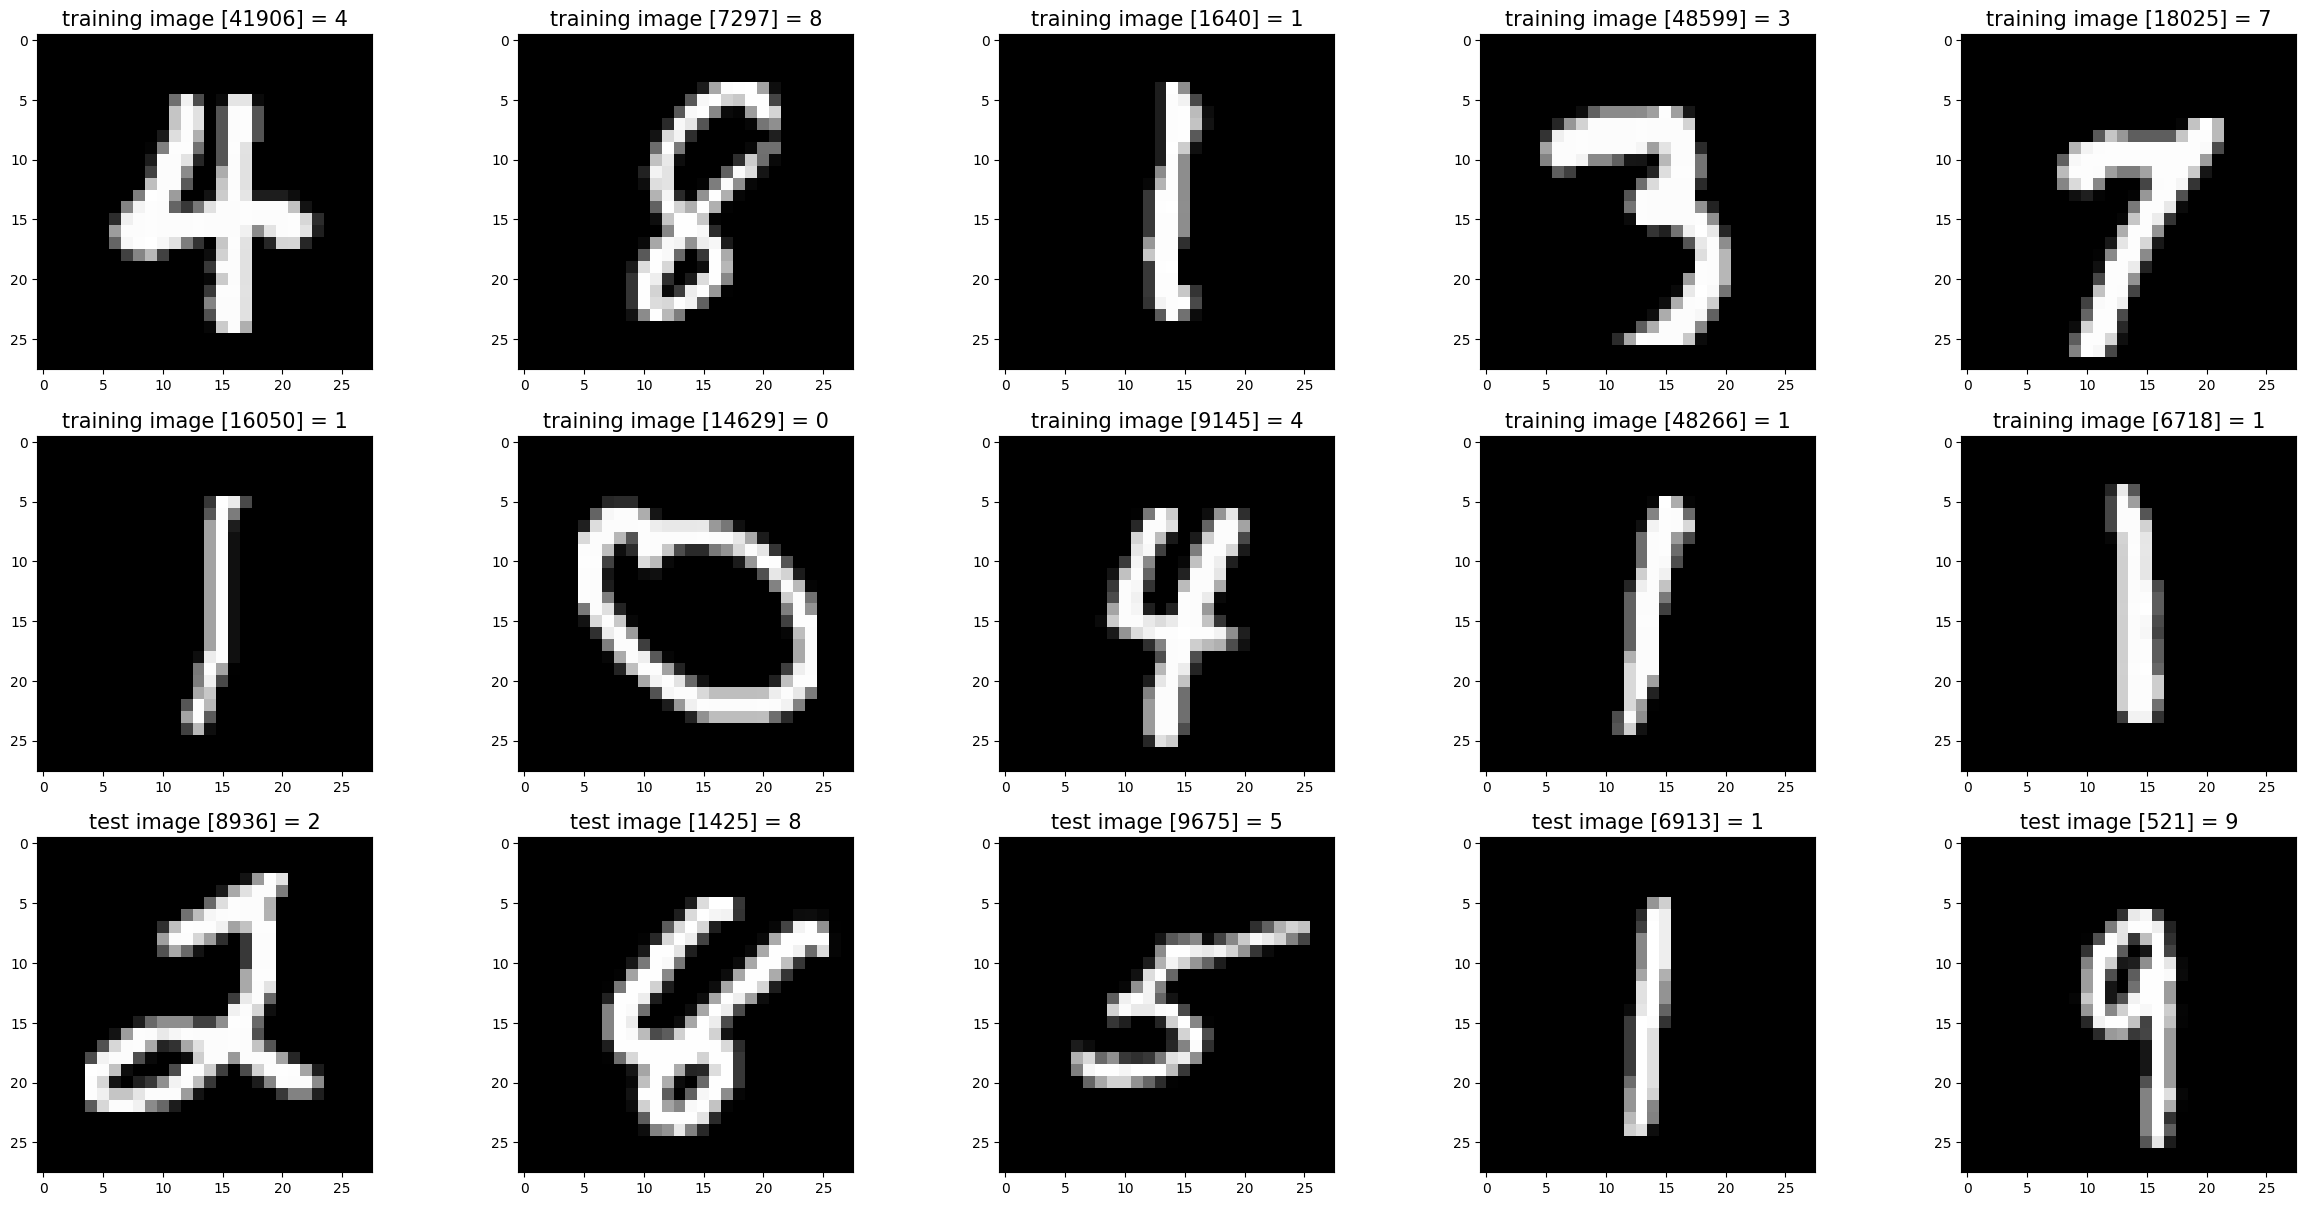

In [99]:
#
# Verify Reading Dataset via MnistDataloader class
#

# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'C:\\Users\\L_W\\Documents\\code\\Sketch2Num\\z_mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [100]:
def binarize(image):
    x_train = np.array(image)
    return (x_train > 127).astype(np.uint8) #vectorization = win

In [101]:
binary_x_train = binarize(x_train)

binary_x_test = binarize(x_test)


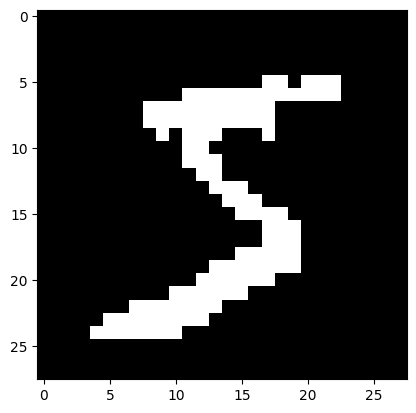

In [102]:
plt.imshow(binary_x_train[0], cmap='gray')

In [103]:
def make_loader(X, y, batch_size):
    x_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).long()  # Use .long() for classification labels

    x_tensor = x_tensor.view(-1, 1, 28, 28)

    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [104]:
batch_size=64

df = pd.read_csv("c:\\Users\\L_W\\Documents\\code\\Sketch2Num\\data\\record.csv")

y_dev = df["label"]

x_dev = df.iloc[:,1:785].values.reshape(165,28,28)

dev_loader = make_loader (x_dev,
                          np.array(y_dev),
                          batch_size)

train_loader = make_loader(np.array(binary_x_train),
                           np.array(y_train),
                           batch_size)

test_loader = make_loader (np.array(binary_x_test),
                           np.array(y_test),
                           batch_size)



### Model

In [105]:
import torch
import torch.nn as nn

In [106]:
#CNN model

class Model_CNN (nn.Module):
    def __init__(self):
        super(Model_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear (128,10)

    def forward (self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 5 *5)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x
    

In [107]:
# evaluate error
def evaluate(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            pred = model(inputs)
            _, prediction = torch.max(pred,1)
            correct+= (prediction == labels).sum().item()
            total += labels.size(0)
        return 100 * correct / total

In [108]:
# train single epoch

def train_one_epoch(TrainLoader, model, loss_fn, optimizer):
    model.train()
    for X_train, y_train in TrainLoader:
        
        pred = model(X_train)
        loss = loss_fn(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

In [ ]:
#initialization
torch.manual_seed(42)

model = Model_CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00025)

epochs = 5

In [111]:
#initialization
torch.manual_seed(42)

model = Model_CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00025)

epochs = 5


train_acc = []
test_acc = []
dev_acc = []

for epochs in range(epochs):


    model = train_one_epoch(TrainLoader = train_loader,
                            model = model, 
                            loss_fn = loss_fn, 
                            optimizer = optimizer)
    
    train_acc.append(evaluate(model, train_loader))

    test_acc.append(evaluate(model, test_loader))

    dev_acc.append(evaluate(model, dev_loader))

dev_acc



[44.24242424242424,
 53.333333333333336,
 60.0,
 61.81818181818182,
 64.24242424242425]

In [112]:
#initialization
torch.manual_seed(42)

model = Model_CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00025)

epochs = 5


train_acc = []
test_acc = []
dev_acc = []

for epochs in range(epochs):


    model = train_one_epoch(TrainLoader = train_loader,
                            model = model, 
                            loss_fn = loss_fn, 
                            optimizer = optimizer)
    
    train_acc.append(evaluate(model, train_loader))

    test_acc.append(evaluate(model, test_loader))

    dev_acc.append(evaluate(model, dev_loader))

dev_acc

[44.24242424242424,
 53.333333333333336,
 60.0,
 61.81818181818182,
 64.24242424242425]

In [ ]:
dev_acc

[44.24242424242424,
 53.333333333333336,
 60.0,
 61.81818181818182,
 64.24242424242425]

In [95]:
dev_acc 

[51.515151515151516,
 62.42424242424242,
 62.42424242424242,
 63.63636363636363,
 66.06060606060606]

Text(0, 0.5, 'acc')

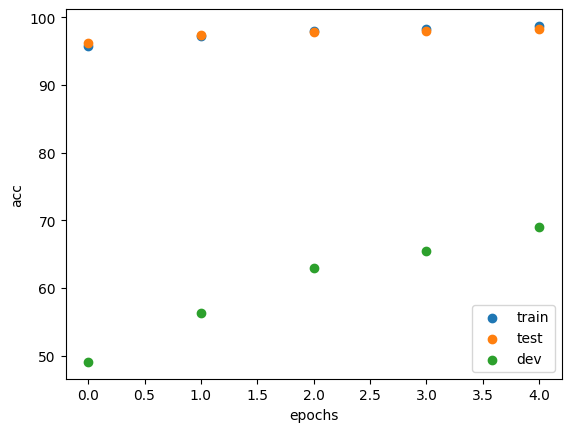

In [60]:
plt.scatter(np.arange(len(train_acc)),train_acc, label = "train")
plt.scatter(np.arange(len(train_acc)),test_acc, label = "test")
plt.scatter(np.arange(len(train_acc)),dev_acc, label = "dev")

plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
